Есть данные о такси-компании, которая хочет изучить отток водителей и посмотреть, какие есть различия между водителями, которые покидают сервис, и которые остаются. Нужно сформулировать и протестировать гипотезы, выделить группы водителей, которые наиболее подвержены "оттоку". На основе результатов сделать выводы о том, что можно улучшить в сервисе, чтобы в дальнейшем внести изменения.

### Вопросы для проверки:
* Проверить, есть ли различия в размерах оттока клиентов в разных городах (churn, city)
* Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)
* Может ли отток быть связан с активностью в первые 30 дней после регистрации? (churn, trips_in_first_30_days)

## Описание данных
* `city` – город
* `phone` – основное устройство, которое использует водитель
* `signup_date` – дата регистрации аккаунта (YYYYMMDD)
* `last_trip_date` – дата последней поездки (YYYYMMDD)
* `avg_dist` – среднее расстояние (в милях) за поездку в первые 30 дней после регистрации
* `avg_rating_by_driver` – средняя оценка поездок водителем
* `vg_rating_of_driver` – средняя оценка поездок водителя
* `surge_pct` – процент поездок, совершенных с множителем > 1 (кажется когда большая загруженность и тд)
* `avg_surge` – средний множитель всплеска за все поездки этого водителя
* `trips_in_first_30_days` – количество поездок, которые совершил водитель в первые 30 дней после регистрации
* `luxury_car_user` – TRUE, если пользователь в первые 30 дней использовал премиум-автомобиль
* `weekday_pct` – процент поездок пользователя, совершенных в будние дни

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import chi2_contingency, chi2, kruskal, mannwhitneyu
import scikit_posthocs as sp
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
df = pd.read_csv('churn.csv')
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,luxury_car_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [5]:
df.last_trip_date = pd.to_datetime(df.last_trip_date)
df.signup_date = pd.to_datetime(df.signup_date)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   avg_dist                50000 non-null  float64       
 1   avg_rating_by_driver    49799 non-null  float64       
 2   avg_rating_of_driver    41878 non-null  float64       
 3   avg_surge               50000 non-null  float64       
 4   city                    50000 non-null  object        
 5   last_trip_date          50000 non-null  datetime64[ns]
 6   phone                   49604 non-null  object        
 7   signup_date             50000 non-null  datetime64[ns]
 8   surge_pct               50000 non-null  float64       
 9   trips_in_first_30_days  50000 non-null  int64         
 10  luxury_car_user         50000 non-null  bool          
 11  weekday_pct             50000 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(6), int

In [6]:
df['days_since_last_trip'] = df.last_trip_date.max() - df.last_trip_date
df['days_since_last_trip']

0        14 days
1        57 days
2       175 days
3         2 days
4       108 days
          ...   
49995    26 days
49996   157 days
49997    40 days
49998   167 days
49999    72 days
Name: days_since_last_trip, Length: 50000, dtype: timedelta64[ns]

In [7]:
df['days_since_last_trip'] = df['days_since_last_trip'].dt.days
df['days_since_last_trip']

0         14
1         57
2        175
3          2
4        108
        ... 
49995     26
49996    157
49997     40
49998    167
49999     72
Name: days_since_last_trip, Length: 50000, dtype: int64

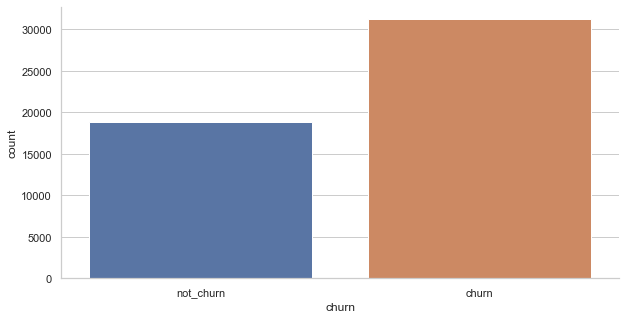

In [25]:
df['churn'] = df.days_since_last_trip.apply(lambda x: 'churn' if x > 30 else 'not_churn')
sns.countplot('churn', data=df)
sns.despine()

In [18]:
pd.crosstab(df.churn, df.city)

city,Astapor,King's Landing,Winterfell
churn,,,
churn,12306,3767,15123
not_churn,4228,6363,8213


In [21]:
import plotly.express as px
fig = px.histogram(df[['churn', 'city']].dropna(), x='churn', 
                   color='city')
fig.show()

In [22]:
stat, p, dof, expected = chi2_contingency(pd.crosstab(df.churn, df.city))
stat, p

(3821.5510225559633, 0.0)

In [23]:
prob = 0.95
alpha = 1.0 - prob
if p <= alpha:
    print('Отклоняем H0')
else:
    print('Не отклоняем H0')

Отклоняем H0


Для проверки этой гипотезы я использую `ХИ-КВАДРАТ`, поскольку переменные: `ОБЕ КАТЕГОРИАЛЬНЫЕ`. Нулевая гипотеза `ОТКЛОНЯЕТСЯ`, поскольку `p-value < 0. 05`. Значит, `ВЗАИМОСВЯЗЬ ЕСТЬ`.



### Есть ли разница в активности в первые 30 дней с момента регистрации между водителями из разных городов? (city, trips_in_first_30_days)

Проверим распределение на нормальность:
```python
from scipy.stats import shapiro
```

Не забудьте использовать .sample(1000).

In [27]:
df[['city','trips_in_first_30_days']].head()


,city,trips_in_first_30_days
0,King's Landing,4
1,Astapor,0
2,Astapor,3
3,King's Landing,9
4,Winterfell,14


In [29]:
from scipy.stats import shapiro
shapiro(df.trips_in_first_30_days)

ShapiroResult(statistic=0.5649267435073853, pvalue=0.0)

### Распределение ненормальное

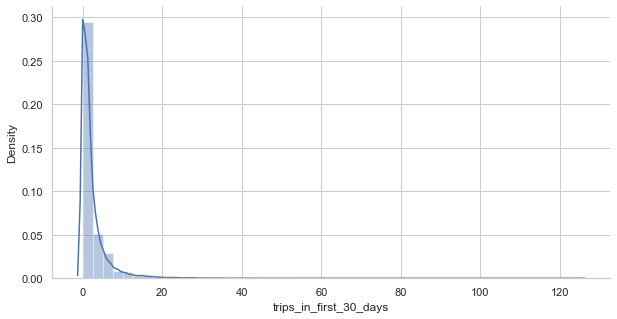

In [32]:
sns.distplot(df.trips_in_first_30_days)
sns.despine()

In [37]:
ast = df[df.city == 'Astapor'].trips_in_first_30_days
king = df[df.city == "King's Landing"].trips_in_first_30_days
winter = df[df.city == 'Winterfell'].trips_in_first_30_days

In [42]:
print(shapiro(ast.sample(1000)))
print(shapiro(king.sample(1000)))
print(shapiro(winter.sample(1000)))

ShapiroResult(statistic=0.5571873188018799, pvalue=1.6815581571897805e-44)
ShapiroResult(statistic=0.6363525390625, pvalue=1.3458070451375543e-41)
ShapiroResult(statistic=0.6079733967781067, pvalue=1.0663881313511858e-42)


### Распределения не являются нормальными, поэтому используем непараметрический аналог ANOVA – критерий Краскела-Уоллиса

In [43]:
kruskal(ast, king, winter)

KruskalResult(statistic=221.32105325317454, pvalue=8.724567791938856e-49)

### Есть статзначимые различия

In [47]:
churn = df[df.churn == 'churn'].trips_in_first_30_days
not_churn = df[df.churn == 'not_churn'].trips_in_first_30_days

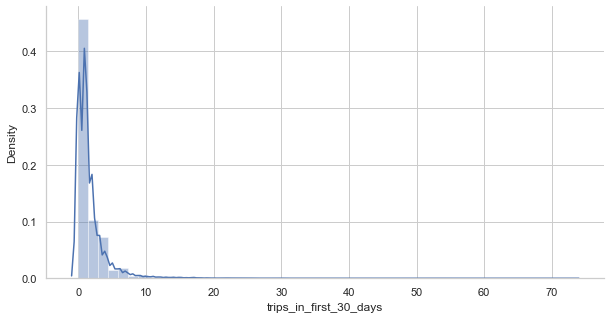

In [49]:
sns.distplot(churn)
sns.despine()

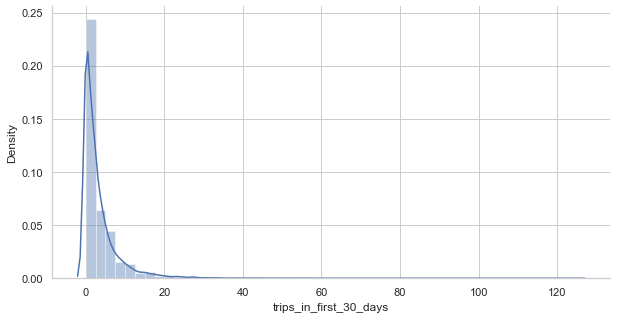

In [50]:
sns.distplot(not_churn)
sns.despine()

In [51]:
mannwhitneyu(churn, not_churn)

MannwhitneyuResult(statistic=234767452.0, pvalue=0.0)

Text(0.5, 1.0, 'Зависимость между ушедшими и не ушедшими')

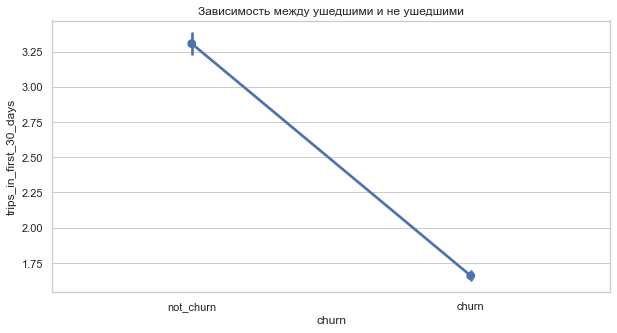

In [55]:
sns.pointplot(x = 'churn', y = 'trips_in_first_30_days', data = df)
plt.title('Зависимость между ушедшими и не ушедшими')

Распределение переменной trips_in_first_30_days `НЕ ЯВЛЯЕТСЯ НОРМАЛЬНЫМ`, поэтому для проверки гипотезы я использую `U-КРИТЕРИЙ МАННА-УИТНИ`. Результат оказался статистически `ЗНАЧИМ`. Значит, `ЗНАЧИМЫЕ РАЗЛИЧИЯ ЕСТЬ, УШЕДШИЕ ПОЛЬЗОВАТЕЛИ БЫЛИ МЕНЕЕ АКТИВНЫ`.